# 1회차

# Analysis packages

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

# Load the data

In [81]:
trainset = pd.read_csv('./train.csv')
testset = pd.read_csv('./test.csv')

# Few quick observation

예제 데이터의 설명을 기반으로 몇 가지 관찰을 할 수 있습니다.

정의된 그룹은 거의 없으며 이러한 그룹에 속하는 피처에는 이름에 패턴(ind, reg, car, cal)이 포함됩니다. ind는 아마도 개인(individual), reg는 등록(registration), car는 말 그대로 자동차, calc은 계산된 영역을 나타내는 것 같습니다.

postfix bin은 이진 피처에 사용됩니다. postfix cat은 범주형 피처에 사용됩니다.

bin 또는 cat이 없는 피처는 정수(ordinal), 실수(continous)입니다.

결측값은 -1로 표시됩니다.

예측의 대상이 되는 값이 target 칼럼에 있습니다. 이는 해당 피보험자에 대한 청구가 제기되었는지 여부를 나타냅니다.

id는 정수형 데이터 입니다.

이제 데이터를 통해 해석이 맞는지 살펴보겠습니다.


In [82]:
trainset.head(15)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,1.8,2.332649,10,0,-1,0,0,14,1,1,0,1,104,2,0.445982,0.879049,0.406202,3.000000,0.7,0.8,0.4,3,1,8,2,11,3,8,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.6,0.1,0.617454,6,1,-1,0,1,11,1,1,0,1,99,2,0.316228,0.639683,0.368782,3.162278,0.2,0.6,0.5,2,2,8,1,8,3,10,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,0,0,0,0,0,0,13,1,0,0,0.7,0.4,0.607248,11,1,0,0,0,11,1,1,2,1,30,3,0.446990,0.900574,0.374833,3.316625,0.1,0.5,0.1,1,2,7,1,6,1,13,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,0,0,0,0,0,0,6,1,0,0,0.9,0.7,0.901388,10,1,-1,0,1,14,1,1,0,1,68,3,0.400000,0.780641,0.407431,2.828427,0.9,0.8,0.6,3,1,7,3,9,4,11,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,4,0,0,1,0.9,1.4,2.316652,11,0,0,1,0,14,1,1,2,1,104,2,0.447214,1.458184,0.390256,3.605551,0.7,0.8,0.8,2,2,8,2,9,1,11,3,5,0,6,0,1,0,0,1,0


cat 값이 0부터 n의 정수값을 갖는 범주형임을 알 수 있고, bin은 binary입니다.

이제 데이터에 행과 열이 얼마나 있는지 살펴보겠습니다.

In [83]:
print('Train dataset (rows, cols):', trainset.shape, '\nTest dataset (rows,cols):', testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows,cols): (892816, 58)


트레이닝 셋에는 59개의 컬럼이 있고, 테스트 셋에는 58개의 컬럼이 있습니다. 이는 target 컬럼의 차이이므로 괜찮습니다. 

In [84]:
print('Column in train and not in test dataset:', set(trainset.columns)-set(testset.columns))

Column in train and not in test dataset: {'target'}


# Introduction of metadata

데이터 조작을 쉽게 하기 위해, 우리는 트레이닝 셋의 변수에 몇 가지 메타 정보를 연결할 것입니다. 이렇게 하면 분석, 검사 또는 모델링을 위한 다양한 유형의 피처를 쉽게 선택할 수 있습니다. car,ind,reg 및 calc의 피처에 범주형 필드를 사용하고 있습니다.

사용할 메타데이터는 다음과 같습니다.
- use: input,ID,target
- type: nominal,interval,ordinal,binary
- preserve: True or False
- dataType: int,float,char
- category: ind,reg,car,calc

In [85]:
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
        
    # Defining the data type
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


메타 데이터 정제를 완료했으니 한번 범주형 피처를 예를 들어 추출해보겠습니다.

In [86]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

이제 카테고리 별 피처가 얼마나 있는지 확인해보겠습니다.

In [87]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


20개의 calculated 피처, 16개의 car, 18 individual, 3 registration 피처가 있습니다.

이번에는 use와 type에 따른 피처의 개수를 살펴보겠습니다.

In [88]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


id 와 target은 1개입니다. (이는 당연합니다) input에서 17개의 바이너리 피처, 14개의 범주형 피처, 16개의 정수형 피처, 10개의 실수형 피처가 있습니다.

# Data analysis and statisics

## Target variable

3.7826188541597645

<Figure size 432x288 with 0 Axes>

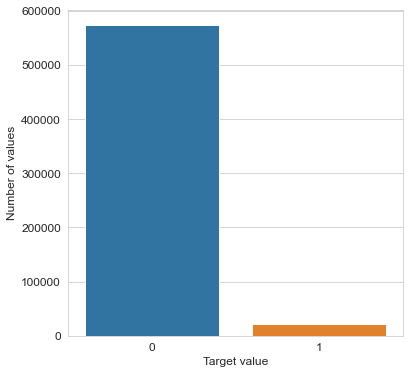

In [89]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
y[1]/y[0]*100

target 에서 오직 3.78%의 데이터가 1을 가지고 있습니다. 이는 트레이닝 셋이 매우 불균형함을 의미합니다. 따라서 target = 0인 데이터를 언더샘플링 하거나 target = 1인 데이터를 오버샘플링 해야 합니다. 

데이터가 매우 크므로 언더샘플링을 진행하겠습니다.

## Real features

In [90]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


### Features with missing values

ps_reg_03, ps_car_12, ps_car_14가 결측치를 가지고 있습니다.(최솟값 -1)

### Registration features

ps_reg_01과 ps_reg_02는 분모가 10인 분수입니다. (0.1, 0.2, 0.3, ...)

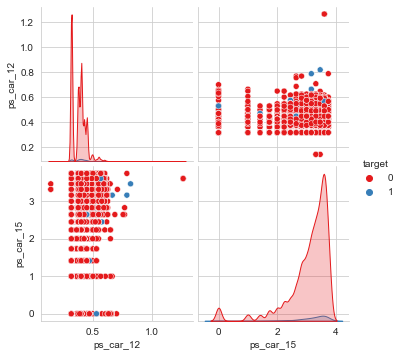

In [91]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Calculated Features
ps_calc_01, ps_calc_02, ps_calc_03은 비율과 관련된 것 같으면서 매우 비슷한 분포를 가지고 있습니다. 셋 다 최대값이 0.9입니다.

이번에는 타입이 real인 피처에 대해 시각화를 진행해보겠습니다.

<Figure size 432x288 with 0 Axes>

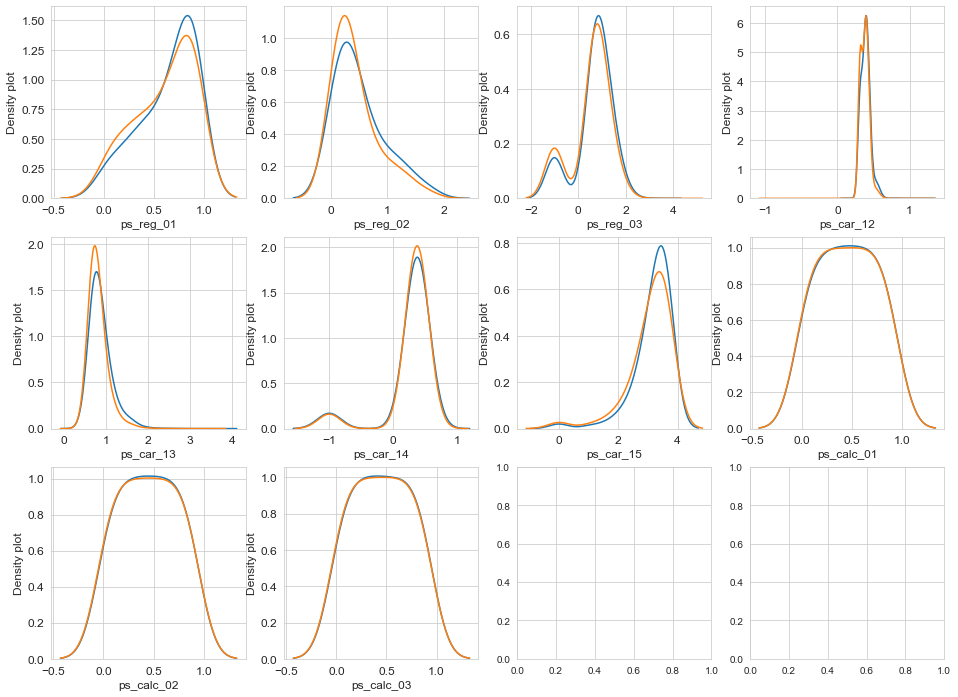

In [92]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize = 12)
    plt.xlabel(feature, fontsize = 12)
    locs, labells = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_reg_01, ps_reg_02, ps_car_13, ps_car15는 target=0과 target=1의 분포 차이가 어느정도 있습니다.

그렇다면 이번에는 히트맵을 그려보겠습니다.

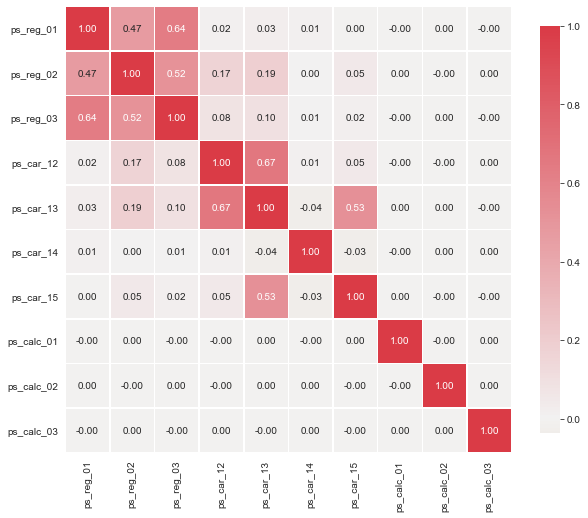

In [93]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

히트맵을 통해 강한 양의 상관관계가 있는 피처들을 아래와 같이 정리했습니다.
- ps_reg_01, ps_reg_02 (0.47)
- ps_reg_01, ps_reg_03 (0.64)
- ps_reg_02, ps_reg_03 (0.52)
- ps_car_12, ps_car_13 (0.67)
- ps_car_13, ps_car_15 (0.53)

상관된 값들에 대해 pairplot을 도시해보겠습니다. 표본에서 2%의 데이터만 사용합니다.

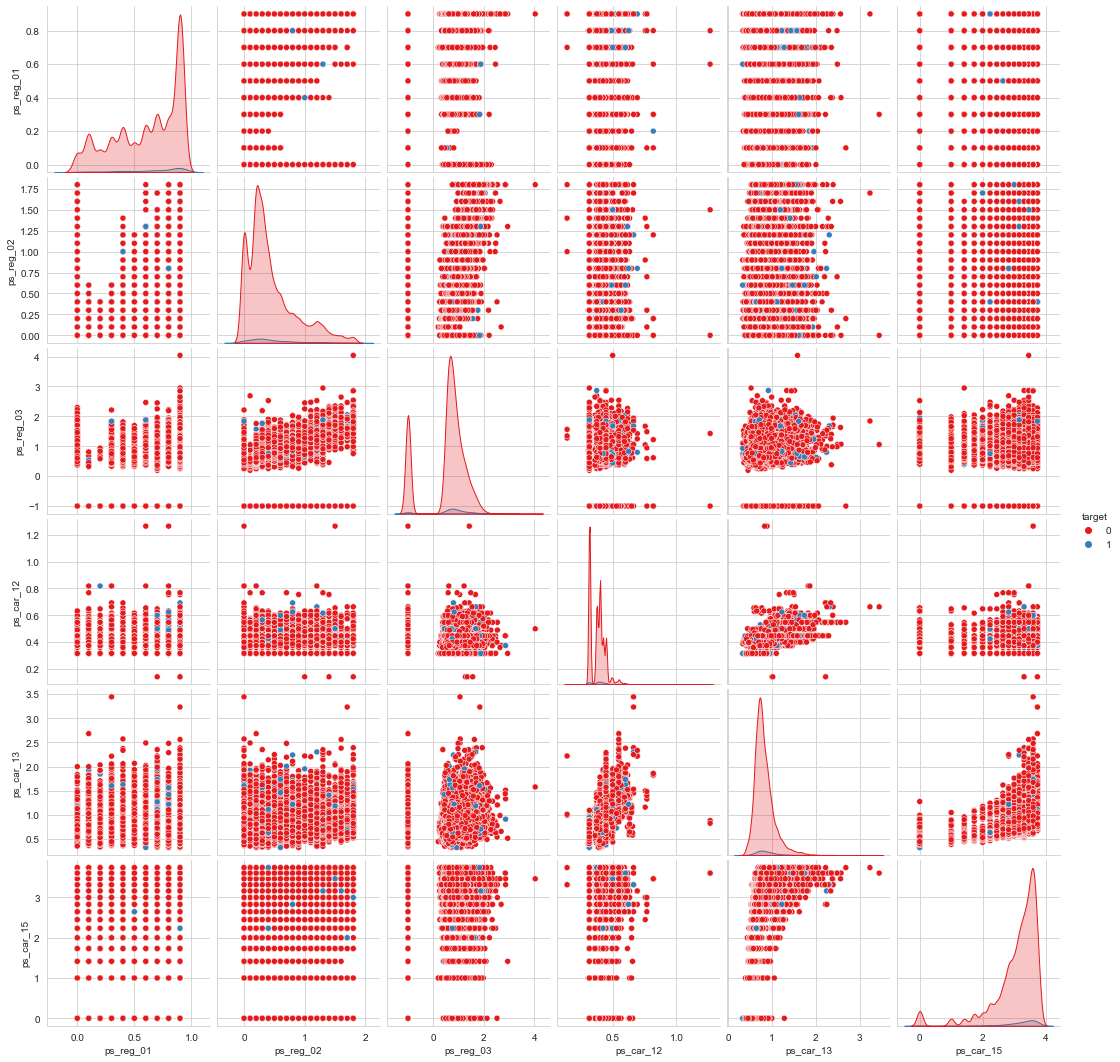

In [94]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

## Binary features

In [95]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


트레이닝 셋의 바이너리 데이터에 대해 분포도를 그려보겠습니다. 파란 그래프는 0을 나타내고 빨간 그래프는 1을 나타냅니다.

<Figure size 432x288 with 0 Axes>

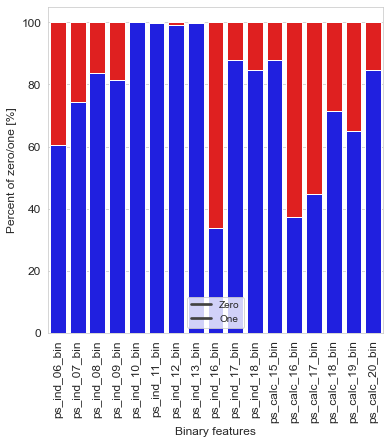

In [96]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, color='red', bottom=zero_list)
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Zero', 'One'], loc='best')
plt.show()

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin은 매우 작은 1값을 가지고 있습니다. 반면 ps_ind_16_bin과 ps_calc_16_bin, ps_calc_17_bin은 1값이 거의 60%에 달합니다.

이번에는 값에 따른 target 값의 분포를 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

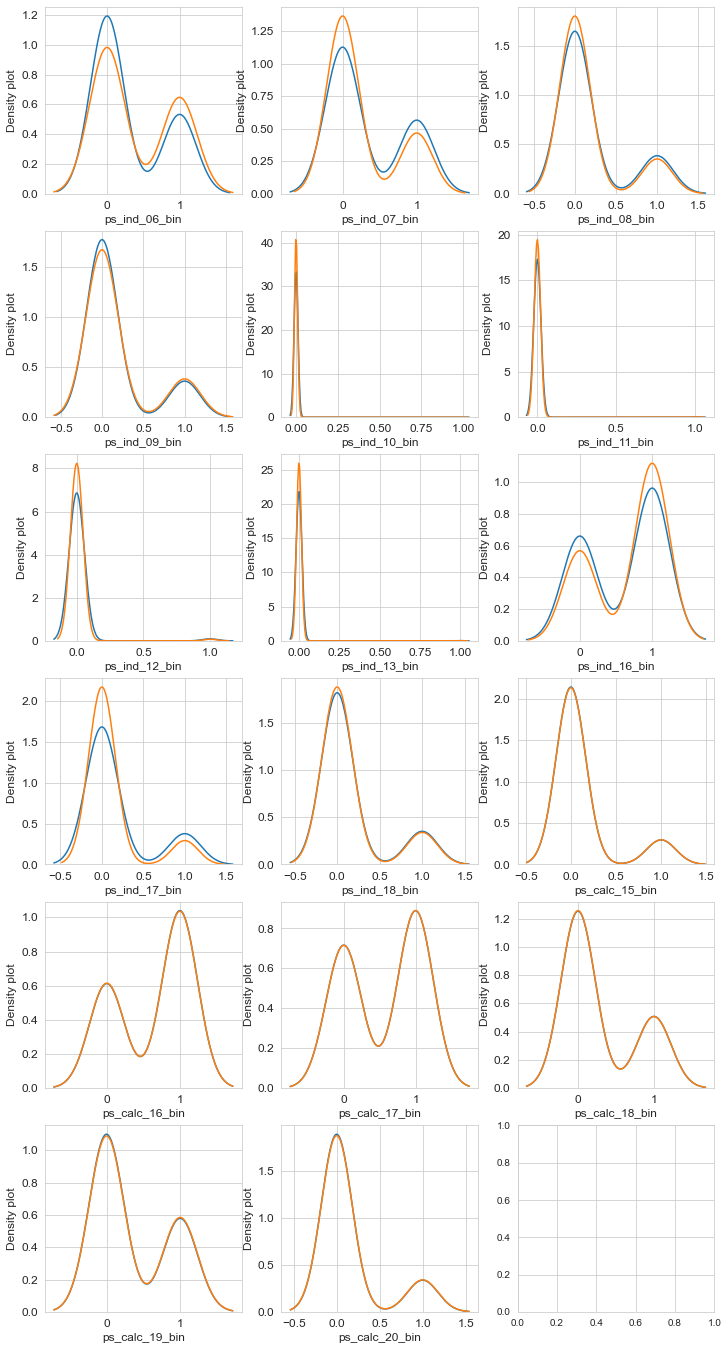

In [97]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin 은 1과 0 값에 차이가 있습니다.

## Categorical features
두 가지 방법으로 범주형 데이터의 분포를 나타낼 것입니다. 먼저 범주 값당 target=1의 백분율을 계산하고 막대 그림을 사용하여 백분율을 나타냅니다.

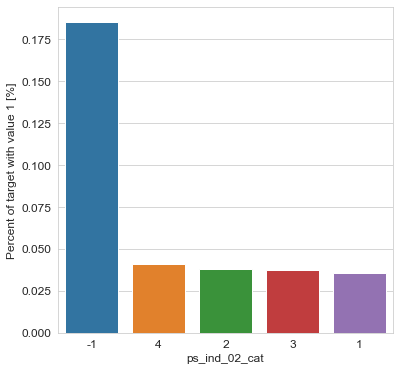

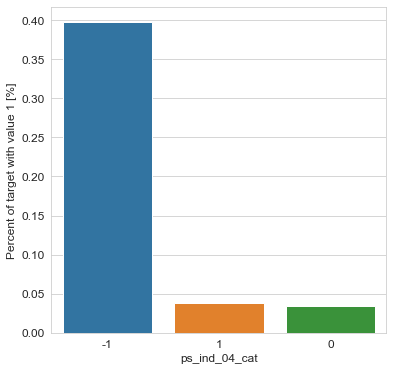

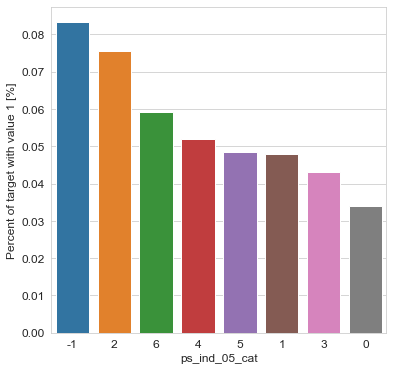

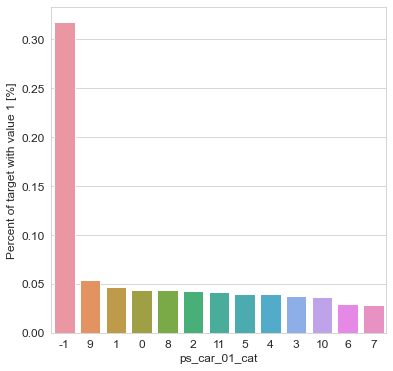

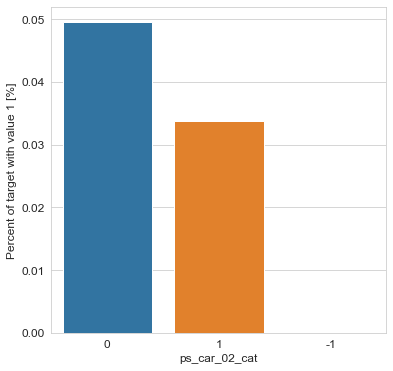

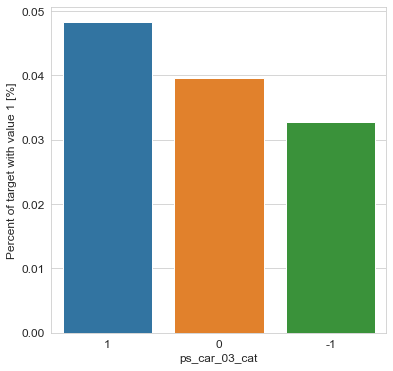

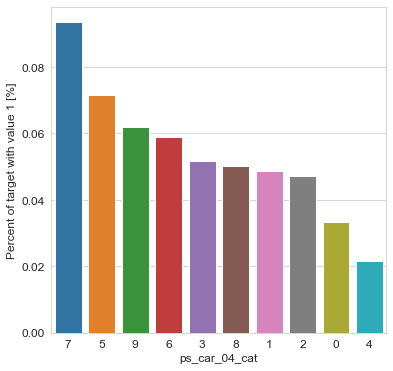

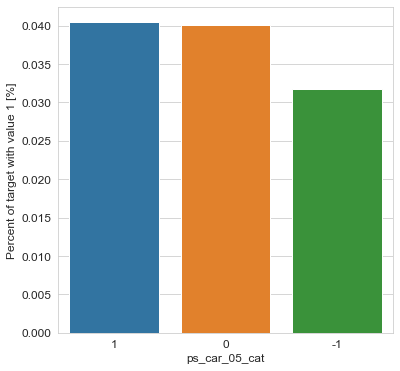

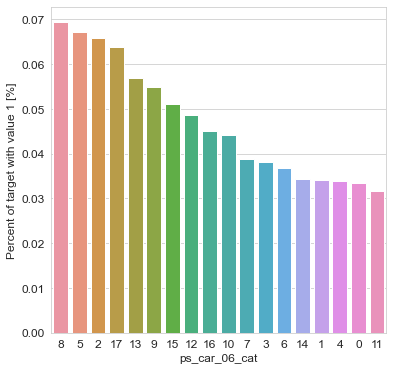

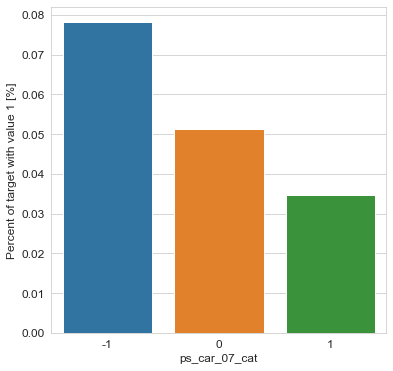

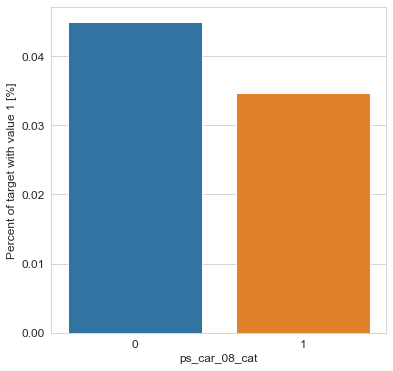

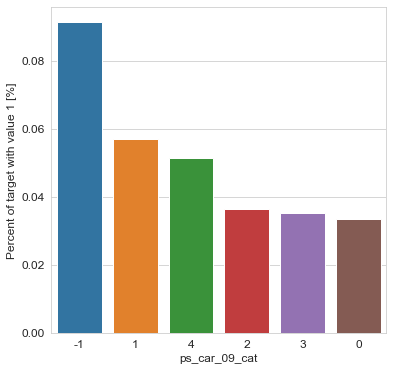

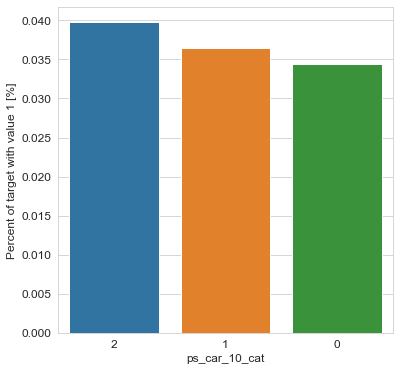

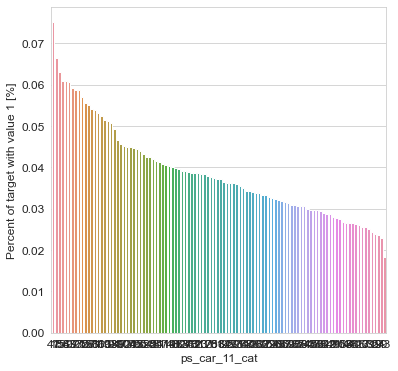

In [98]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    # Calculate the percentage of target = 1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)

이번에는 categorical 피처들에 밀도 플롯을 적용해보겠습니다. 

<Figure size 432x288 with 0 Axes>

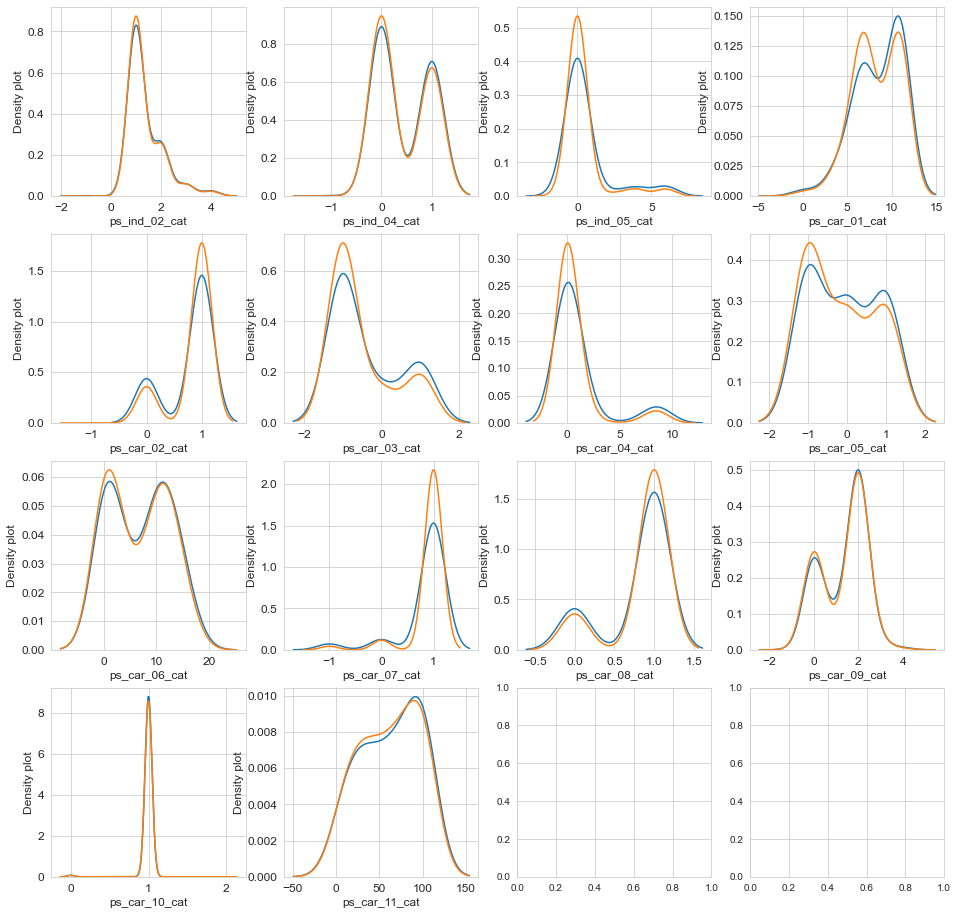

In [99]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

## Data unbalance between train and test data
트레인셋과 테스트셋의 분포 차이를 비교해보겠습니다.

먼저 reg 피처입니다.

<Figure size 432x288 with 0 Axes>

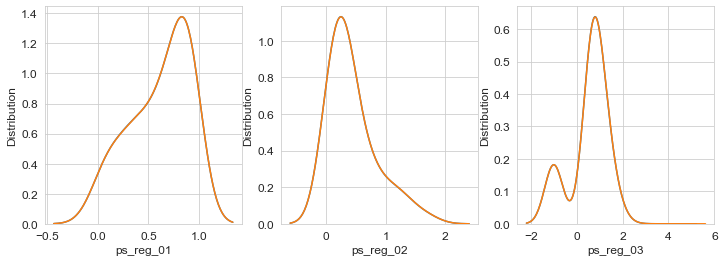

In [100]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

모든 reg 피처는 트레이닝과 테스트셋이 잘 맞춰져있습니다.

이번에는 car 피처를 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

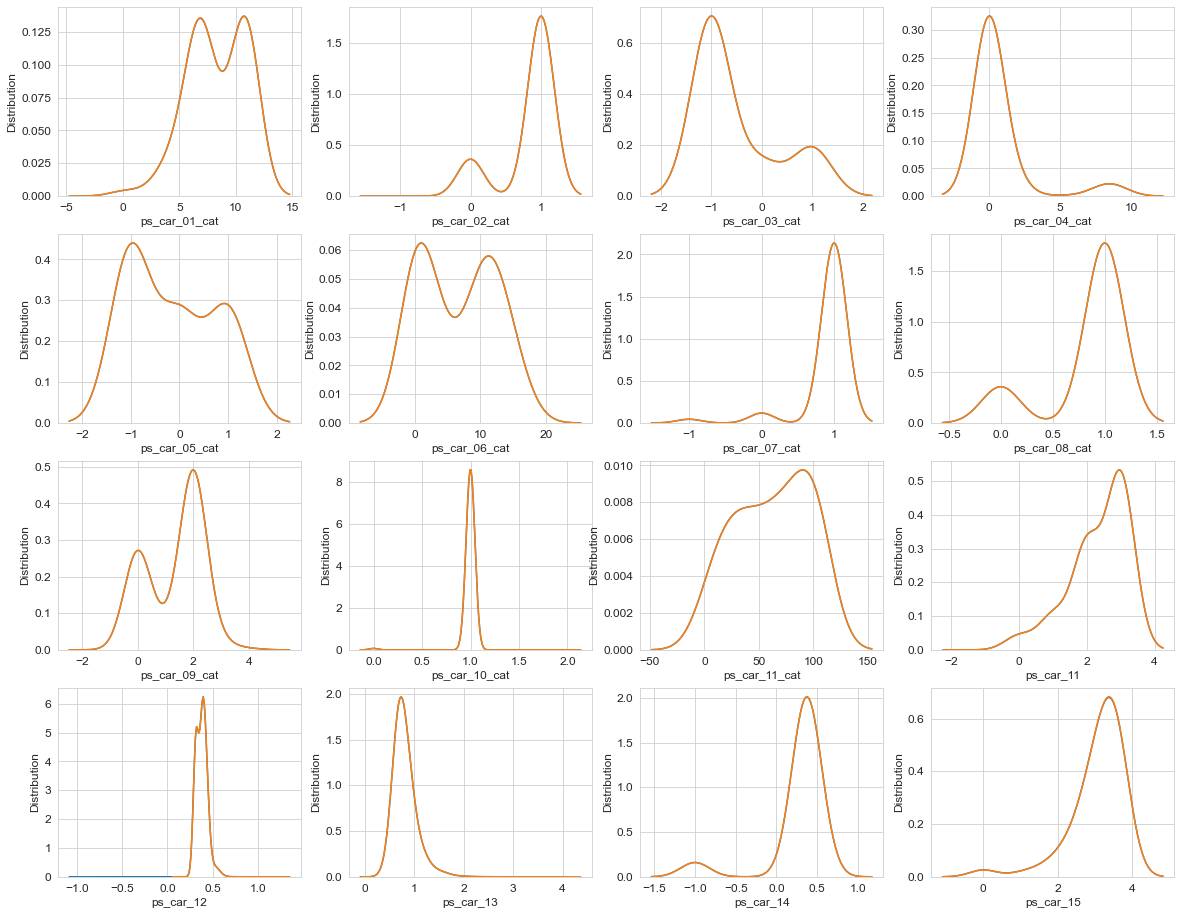

In [101]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

car 피처도 마찬가지로 잘 맞춰져 있습니다.

이번에는 ind 값을 보겠습니다.

<Figure size 432x288 with 0 Axes>

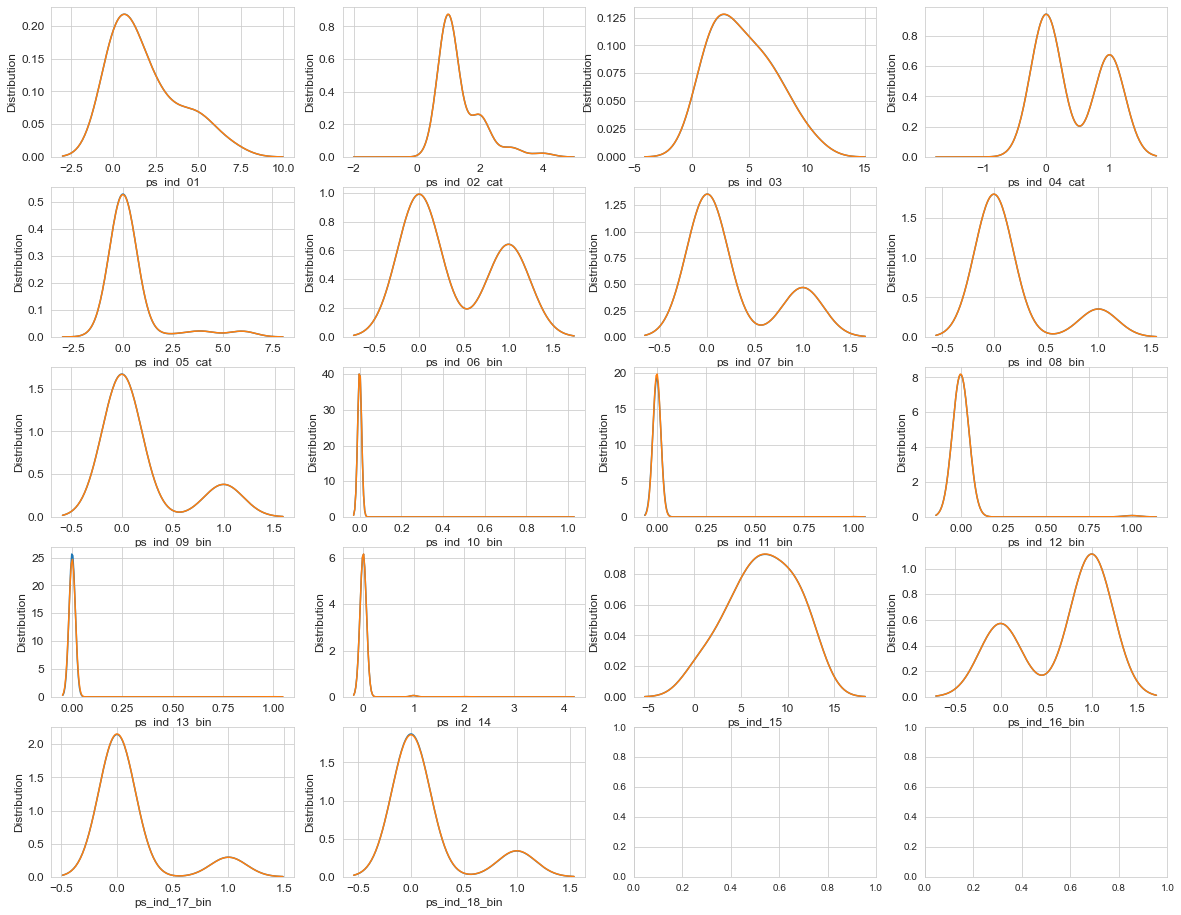

In [102]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ind 피처도 좋습니다.

calc 피처를 보겠습니다.

<Figure size 432x288 with 0 Axes>

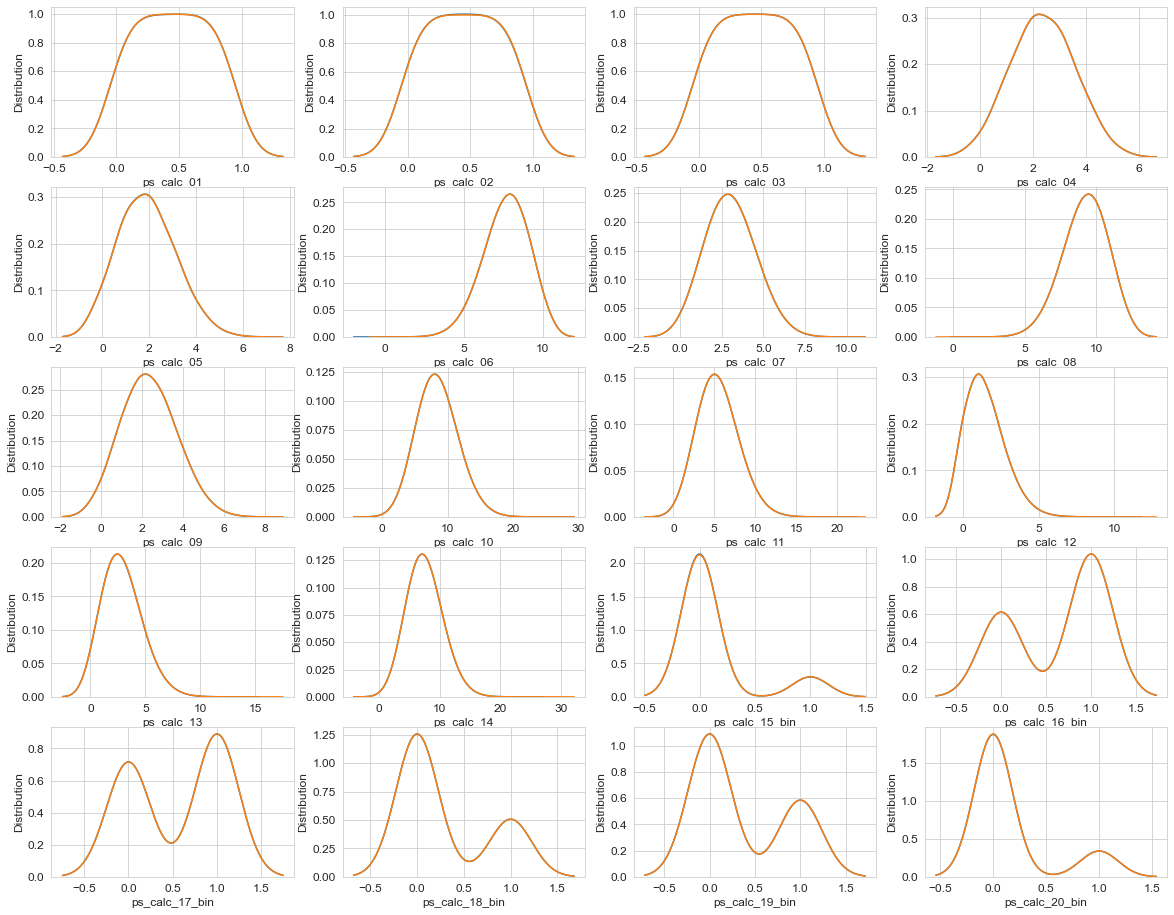

In [103]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

calc도 마찬가지입니다. calc 피처는 모두 엔지니어링 되어서 실제로 관련이 없을 수도 있습니다. 이는 하나 이상의 예측 모델을 사용해서 CV 점수를 통해 연속적인 제거를 통해서만 평가할 수 있습니다.

# Check data quality

결측치에 대해 관찰해 보겠습니다.

In [104]:
vars_with_missing = []

for feature in trainset.columns:
    missing = trainset[trainset[feature] == -1][feature].count()
    if missing > 0:
        vars_with_missing.append(feature)
        missings_perc = missing/trainset.shape[0]
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missing, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


# Prepare the data for model

## Drop calc columns
위에서 언급했듯이, calc 컬럼을 제거하도록 하겠습니다.

In [105]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

## Drop varibles with too many missing values
결측값이 매우 많은 ps_car_03_cat, ps_car_05_cat 피처를 제거하겠습니다.

In [106]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False # Updating meta

In [107]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series = None,
                 tst_series = None,
                 target = None,
                 min_samples_leaf = 1,
                 smoothing = 1,
                 noise_level = 0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    # Compute smoothing
    smoothing = 1/(1+np.exp(-(averages['count'] - min_samples_leaf)/smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account 
    averages[target.name] = prior * (1-smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name), 
                             averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                            on = trn_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
    tst_series.to_frame(tst_series.name),
    averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on = trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it))
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## Replace ps_car_11_cat with encoded value
target_encode 함수를 사용하여 ps_car_11_cat 피처를 인코딩 값으로 대체하겠습니다.

In [108]:
train_encoded, test_encoded = target_encode(trainset['ps_car_11_cat'], testset['ps_car_11_cat'], target=trainset.target, min_samples_leaf=100, smoothing=10, noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

## Balance target variable
target 변수가 매우 불균형적입니다. 위에서 설명한대로 언더샘플링을 진행하겠습니다.

In [109]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampling_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampling_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampling_idx = shuffle(idx_0, random_state=314, n_samples=undersampling_nb_0)

# Construct list with remaining indices
idx_list = list(undersampling_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## Replace -1 values with NaN

In [110]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

## Dummify cat values
cat 피처에 대해 더미변수를 생성하겠습니다.

In [111]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

## Drop unused and target columns
id와 target 피처를 분리하겠습니다.

In [112]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

In [113]:
print('Train dataset (rows, cols):', trainset.values.shape, '\nTest dataset (rows, cols)', testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols) (892816, 91)


# Prepare the model

## Ensemble class for cross validation and ensemble
Ensemble 클래스를 생성하여 Kfold에서 데이터를 분할하고 모델 교육 및 결과를 통합합니다.

클래스에는 다음 4개의 파라미터를 허용하는 init 메서드가 있습니다.
- self - 초기화할 개체입니다.
- n_splits - 사용할 교차 검증 분할 수 입니다.
- stacker - 훈련된 기본 모델에서 예측 결과를 쌓는 데 사용되는 모델입니다.
- base_models - 교육에 사용되는 기본 모델 목록입니다.

두 번째 방법인 fit_predict에는 다음 네 가지 함수가 있습니다.
- 트레이닝 데이터를 n_splits 폴드만큼 나눕니다.
- 각 폴드에 대해 기본 모델을 실행합니다.
- 각 모형을 사용하여 예측합니다.
- stacker을 사용하여 결과를 앙상블합니다.

In [114]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print('Base model %d: fit %s model | fold %d' % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print('cross_score [roc_auc]: %.5f [gini]: %.5f' % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)
        
        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print('Stacker score [gini]: %.5f' % (2 * results.mean() - 1))
        
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

## Parameters for the base models
기본 모델을 준비하기 위해 세 가지의 LightGBM 모델과 한 개의 XGB 모델을 사용하겠습니다.

각 모델은 트레이닝 모델에 사용됩니다.(CV 3 폴드)

In [115]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

## Initialize the models with the parameters
3개의 기본 모델과 1개의 스태킹 모델을 초기화합니다. 

In [117]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)
# Stacking model
log_model = LogisticRegression()

In [118]:
stack = Ensemble(n_splits=3, stacker = log_model, 
                base_models=(lgb_model1, lgb_model2, lgb_model3, xgb_model))

# Run the predictive models
fit_predict 메서드를 호출하여 기본 모델을 학습시키고 각 모델이 target을 예측하고 결과를 앙상블하도록 하겠습니다.

In [119]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc_auc]: 0.63736 [gini]: 0.27471
Base model 1: fit LGBMClassifier model | fold 2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc_auc]: 0.63956 [gini]: 0.27912
Base model 1: fit LGBMClassifier model | fold 3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored.

[19:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_threads } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:02:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b

# Prepare the submission

In [120]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)

In [122]:
submission['target'].unique

<bound method Series.unique of 0         0.078074
1         0.075061
2         0.071621
3         0.059608
4         0.094415
            ...   
892811    0.203837
892812    0.112383
892813    0.097409
892814    0.069486
892815    0.084281
Name: target, Length: 892816, dtype: float64>

# 2회차